In [1]:
import cv2
import sys
import torch
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms

In [20]:
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from options.test_options import TestOptions

sys.argv = sys.argv[:1]

opt = TestOptions().parse() 

------------ Options -------------
Arc_path: arcface_model/arcface_checkpoint.tar
aspect_ratio: 1.0
batchSize: 8
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
crop_size: 512
data_type: 32
dataroot: ./datasets/cityscapes/
display_winsize: 512
engine: None
export_onnx: None
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
how_many: 50
id_thres: 0.03
image_size: 224
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
latent_size: 512
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
multisepcific_dir: ./demo_file/multispecific
nThreads: 2
n_blocks_global: 6
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 3
n_local_enhancers: 1
name: people
nef: 16
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: False
no_simswaplogo: False
norm: batch
norm_G: spectralspadesyncbatch3x3
ntest: inf
onnx: None
output_nc: 3
output_path: ./output/
phase: test
pic_a_path: G:/swap_data/ID/elon-m

In [4]:
# 手动给 opt 赋值
opt.use_mask = True

opt.name = 'people'
opt.Arc_path = './checkpoints/arcface_model/arcface_checkpoint.tar'
opt.crop_size = 224

In [5]:
import insightface
from insightface.app import FaceAnalysis

/data1/tides/new/miniconda3/envs/faceSwap/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
app = FaceAnalysis(name='antelopev2', root='./checkpoints')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: ./checkpoints/models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvi

In [7]:
netArc = torch.load(opt.Arc_path, map_location=torch.device("cpu"))
netArc = netArc.to(device)
netArc.eval()

/tmp/ipykernel_2522518/2191426767.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netArc = torch.load(opt.Arc_path, map_location=torch.device("cpu"))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu): PReLU(num_parameters=1)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): IRBlock(
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=Tru

In [8]:
from models.fs_model import fsModel

face_swap_model = fsModel()
face_swap_model.initialize(device, netArc, opt)

/home/tides/SimSwap/models/base_model.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(save_path))


In [9]:
source_image_path = 'demo_file/source_image/Iron_man.jpg'
target_video_path = 'demo_file/target_video/jirou_anni.mp4'
result_video_path = 'demo_file/result'
crop_size = 224

## Source图像预处理

In [10]:
source_image = cv2.imread(source_image_path)

In [13]:
source_image.shape

(1073, 769, 3)

In [37]:
from util.face_process import crop_and_align_face
from util.data_process import process_latent_id

source_crop_align_image, source_M = crop_and_align_face(app, source_image, opt.crop_size)
latend_id = process_latent_id(source_crop_align_image, netArc, device)

In [38]:
det_result = app.get(source_image, crop_size)

In [39]:
det_result[0].keys()

dict_keys(['bbox', 'kps', 'det_score', 'landmark_3d_68', 'pose', 'landmark_2d_106', 'gender', 'age', 'embedding'])

In [40]:
from util import face_align_ffhqandnewarc as face_align

In [41]:
source_M, _ = face_align.estimate_norm(det_result[0]["kps"], crop_size) 
source_crop_align_image = cv2.warpAffine(source_image, source_M, (crop_size, crop_size), borderValue=0.0)

In [42]:
source_crop_align_image.shape

(224, 224, 3)

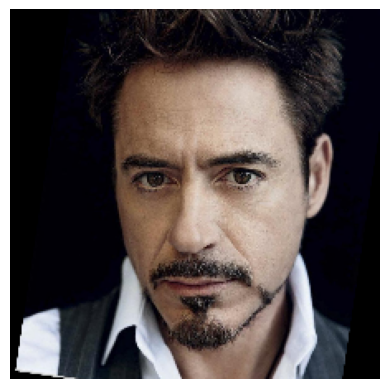

In [43]:
source_crop_align_image_rgb = cv2.cvtColor(source_crop_align_image, cv2.COLOR_BGR2RGB)

plt.imshow(source_crop_align_image_rgb)
plt.axis('off')  
plt.show()

In [44]:
source_crop_align_image_pil = Image.fromarray(cv2.cvtColor(source_crop_align_image, cv2.COLOR_BGR2RGB)) 

In [45]:
transformer_Arcface = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

source_crop_align_image_pil = transformer_Arcface(source_crop_align_image_pil)
source_crop_align_image_pil = source_crop_align_image_pil.view(-1, source_crop_align_image_pil.shape[0], source_crop_align_image_pil.shape[1], source_crop_align_image_pil.shape[2])
source_crop_align_image_pil = source_crop_align_image_pil.to(device)

In [46]:
#create latent id
source_downsample = F.interpolate(source_crop_align_image_pil, size=(112,112))
latend_id = netArc(source_downsample)
latend_id = F.normalize(latend_id, p=2, dim=1)

In [47]:
latend_id.shape

torch.Size([1, 512])

## target视频预处理

In [22]:
target_video = cv2.VideoCapture(target_video_path)
target_video.set(cv2.CAP_PROP_POS_FRAMES, 150)

ret, frame = target_video.read()

In [24]:
frame.shape

(964, 572, 3)

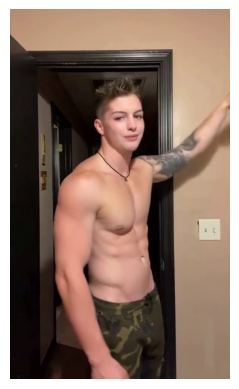

In [23]:
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame_rgb)
plt.axis('off')  
plt.show()

In [25]:
target_detect_results = app.get(frame, crop_size)

/data1/tides/new/miniconda3/envs/faceSwap/lib/python3.8/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [26]:
target_M, _ = face_align.estimate_norm(target_detect_results[0]["kps"], crop_size) 
target_crop_align_image = cv2.warpAffine(frame, target_M, (crop_size, crop_size), borderValue=0.0)

In [27]:
target_crop_align_image.shape

(224, 224, 3)

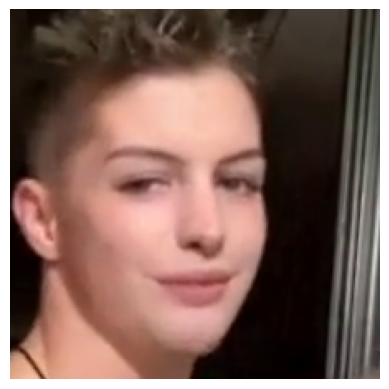

In [28]:
target_crop_align_image_rgb = cv2.cvtColor(target_crop_align_image, cv2.COLOR_BGR2RGB)

plt.imshow(target_crop_align_image_rgb)
plt.axis('off')  
plt.show()

In [31]:
def _totensor(array):
    tensor = torch.from_numpy(array)
    img = tensor.transpose(0, 1).transpose(0, 2).contiguous()
    return img.float().div(255)

In [49]:
target_crop_align_tensor = _totensor(cv2.cvtColor(target_crop_align_image, cv2.COLOR_BGR2RGB))[None,...].cuda()

In [50]:
target_crop_align_tensor.shape

torch.Size([1, 3, 224, 224])

In [28]:
# from util.data_process import process_image_tensor

# target_crop_align_tensor = process_image_tensor(target_crop_align_image)

In [56]:
swap_result = face_swap_model(None, target_crop_align_tensor, latend_id, None, True)

In [57]:
swap_result.shape

torch.Size([1, 3, 224, 224])

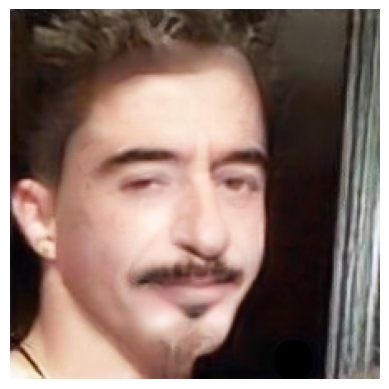

In [58]:
swap_result = swap_result.squeeze(0)  
swap_result = swap_result.permute(1, 2, 0) 
swap_result = swap_result.cpu()
swap_result = (swap_result * 255).clamp(0, 255).byte().numpy()
swap_result = swap_result[..., ::-1]

swap_result = cv2.cvtColor(swap_result, cv2.COLOR_BGR2RGB)

plt.imshow(swap_result)
plt.axis('off')  
plt.show()

In [33]:
from torchsummary import summary

ModuleNotFoundError: No module named 'torchsummary'